<a href="https://colab.research.google.com/github/shreyassathyamangalam/colab_notebooks/blob/main/travel_planner_langraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Key Components

1. StateGraph: The core of our application, defining the flow of our Travel Planner.
2. PlannerState: A custom type representing the state of our planning process.
3. Node Functions: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. LLM Integration: Utilizing a language model to generate the final itinerary.

## Install dependencies

In [ ]:
!pip install -q -U langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2/413.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00


## Import libraries

In [ ]:
import os
from typing import TypedDict, Annotated, List

from langgraph.graph import StateGraph, END

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod

from langchain_groq import ChatGroq

from IPython.display import Image, display

## Define Agent

In [ ]:
from typing import TypedDict, Annotated, List

from langchain_core.messages import HumanMessage, AIMessage

class PlannerState(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "Messages in the conversation"]  # Use Annotated as a type hint
  city: str
  interests: List[str]
  itinerary: str

In [ ]:
llm = ChatGroq(
    temperature=0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

## Define agent function

In [ ]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

## Create and compile the graph

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

## Display the graph structure

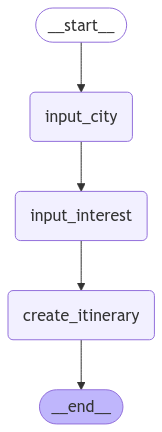

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

## define the function that runs the graph

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
